# Mixture Simulations

We validate the model's ability to assign weights to samples of mixed phenotypes by simulating mixture samples from pairs of different tissues and then checking if the model splits the weights between those two contributing tissues. 

In [1]:
import os
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import pca

sns.set(font_scale=1.25)
sns.set_style("whitegrid")


class Mixture:
    def __init__(self, df_path):
        self.df_path = df_path
        self.df = self._load_df(df_path)
        self.genes = list(self.df.columns[5:])

    @staticmethod
    def _load_df(path):
        """Loads DataFrame"""
        print(f"Reading in {path}")
        if path.endswith(".csv"):
            df = pd.read_csv(path, index_col=0)
        elif path.endswith(".tsv"):
            df = pd.read_csv(path, sep="\t", index_col=0)
        else:
            try:
                df = pd.read_hdf(path)
            except Exception as e:
                print(e)
                raise RuntimeError(f"Failed to open DataFrame: {path}")
        return df

    def select_mixture_tissues(self, number_of_pairs=10):
        """Generates N tissue pairs"""
        # Choose a tissue subset with relevant matches to TCGA
        tissues_to_include = [
            "Adrenal",
            "Bladder",
            "Brain",
            "Breast",
            "Kidney",
            "Liver",
            "Lung",
            "Prostate",
            "Stomach",
            "Thyroid",
        ]
        df = self.df[self.df.tissue.isin(tissues_to_include)]
        df = df.groupby("tissue").filter(lambda x: len(x) > 100)
        tissues = list(combinations(df.tissue.unique(), 2))
        ix = np.random.choice(range(len(tissues)), number_of_pairs, replace=False)

        pairs = []
        for i in ix:
            pairs.append(tissues[i])
        return pairs

    def mixture_matrix(self, t1, t2, out_dir):
        """Create mixture_matrix for one tissue pair"""
        df = self.df
        df1 = df[df.tissue == t1]
        df2 = df[df.tissue == t2]
        path = os.path.join(out_dir, f"{t1}-{t2}.hd5")
        if os.path.exists(path):
            return pd.read_hdf(path)

        samples = []
        for i in range(50):
            s1 = np.random.choice(df1.index, 100, replace=False)
            s2 = np.random.choice(df2.index, 100, replace=False)

            g1 = df1.loc[s1]
            g2 = df2.loc[s2]

            vec = pd.concat([g1, g2])[self.genes].median()
            samples.append(vec)
        mixture_matrix = pd.concat(samples, axis=1).T
        mixture_matrix.index = [f"{t1}-{t2}-{i}" for i in range(50)]

        mixture_matrix.to_hdf(path, key="exp")
        return mixture_matrix

    def mixture_matrices(self, tissues, out_dir):
        """Create mixture matrices for all tissue pairs"""
        matrices = {}
        for t1, t2 in tissues:
            label = f"{t1}-{t2}"
            print(f"Creating mixture matrix for {label}")
            matrices[label] = self.mixture_matrix(t1, t2, out_dir)
        return matrices

    def manifest(self, tissues, matrix_dir, output_dir):
        """Create manifest for outlier Toil run"""
        path = os.path.join(output_dir, "manifest.tsv")
        with open(path, "w") as f:
            f.write("id\tsample\n")
            for t1, t2 in tissues:
                label = f"{t1}-{t2}"
                for i in range(10):
                    matrix_path = os.path.join(matrix_dir, f"{label}.hd5")
                    f.write(f"{label}-{i}\t{matrix_path}\n")

    @staticmethod
    def weight_df(sample_dir: str, only_contributing_tissues=True) -> pd.DataFrame:
        """Creates DataFrame from weights across samples"""
        samples = os.listdir(sample_dir)
        weights = []
        for sample in samples:
            t1, t2 = sample.split("-")[:-1]
            label = f"{t1}-{t2}"
            path = os.path.join(sample_dir, sample, "weights.tsv")
            w = pd.read_csv(path, sep="\t")
            w.columns = ["tissue", "Median", "std"]
            w["sample"] = sample
            w["label"] = label
            if only_contributing_tissues:
                w = w[w.tissue.isin([t1, t2])]
            weights.append(w.drop("std", axis=1))
        weights = pd.concat(weights).reset_index(drop=True)
        return weights.sort_values("label")

    def plot_mixture_pca(self, matrix_dir: str):
        """PCA of mixture samples and the tissues used to generate them"""
        os.listdir(matrix_dir)
        f, ax = plt.subplots(4, 3, figsize=(12, 4 * 4))
        ax = ax.flatten()
        for i, matrix in enumerate(os.listdir(matrix_dir)):
            t1, t2 = os.path.splitext(matrix)[0].split("-")
            mix_df = pd.read_hdf(os.path.join(matrix_dir, matrix))
            mix_df["tissue"] = "Mixture"
            sub = self.df[self.df.tissue.isin([t1, t2])]
            pca_df = pd.concat([sub, mix_df]).dropna(axis=1)
            embedding = pca.PCA(n_components=2).fit_transform(pca_df[self.genes])
            embedding = pd.DataFrame(embedding)
            embedding.columns = ["PCA1", "PCA2"]
            embedding["tissue"] = list(pca_df["tissue"])
            sns.scatterplot(
                data=embedding,
                x="PCA1",
                y="PCA2",
                hue="tissue",
                style="tissue",
                ax=ax[i],
            )
            ax[i].set_title(f"{t1}-{t2}")
        for i in [10, 11]:
            f.delaxes(ax.flatten()[i])   
        plt.tight_layout()
        return ax

    def plot_pca_nearby_tissues(self, matrix_path: str, tissues):
        st_df = pd.read_hdf(matrix_path)
        label = os.path.splitext(os.path.basename(matrix_path))[0]
        st_df["tissue"] = "Mixture"
        sub = self.df[self.df.tissue.isin(tissues)]
        pca_df = pd.concat([st_df, sub]).dropna(axis=1)
        embedding = pca.PCA(n_components=2).fit_transform(pca_df[self.genes])
        embedding = pd.DataFrame(embedding)
        embedding.columns = ["PCA1", "PCA2"]
        embedding["tissue"] = list(pca_df["tissue"])

        f, ax = plt.subplots(figsize=(8, 8))
        sns.scatterplot(
            data=embedding, x="PCA1", y="PCA2", hue="tissue", style="tissue"
        )
        plt.title(f"PCA of {label} Mixtures and Nearby Tissues")
        return ax

    @staticmethod
    def plot_weight_swarm(wdf: pd.DataFrame):
        """Swarmplot of weights for the tissues that comprise the mixture"""
        f, ax = plt.subplots(figsize=(12, 4))
        sns.swarmplot(data=wdf, x="label", y="Median", hue="tissue", size=8, alpha=0.75)
        plt.ylim([0, 1])
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.01, 1))
        plt.axhline(0.5, c="r", alpha=0.5, ls="--")
        plt.xlabel("Mixture-Pairs")
        plt.ylabel("Beta Coefficient Median")
        plt.title(f"Average Beta Coefficient Weight Across Mixture Samples (n=100)")
        return ax

    @staticmethod
    def plot_weight_boxplot(wdf, label):
        """Boxplot of weigts for a single label"""
        weights = wdf[wdf.label == label]
        f, ax = plt.subplots(figsize=(8, 4))
        sns.boxplot(data=weights, x="tissue", y="Median")
        plt.title(f"Boxplot of Weights for {label} Mixtures")
        plt.xlabel("Tissue")
        plt.ylabel("Average Weight")
        plt.ylim([0, 1])
        return ax

In [2]:
m = Mixture('/mnt/data/outlier/gtex.hd5')

Reading in /mnt/data/outlier/gtex.hd5


## Select Tissue Pairs

In [ ]:
tissues = m.select_mixture_tissues()
tissues

## Create Simulated Sample Matrices

In [ ]:
matrix_dir = '/mnt/normsd-outlier-runs/mixture-simulation/matrices'
matrices = m.mixture_matrices(tissues, matrix_dir)

## PCA of Mixture Samples

Run PCA on all mixture samples and the two tissues used to generate the mixture samples. Since this is PCA, the mixture samples should be situated approximately between the clusters of the two contributing tissues.

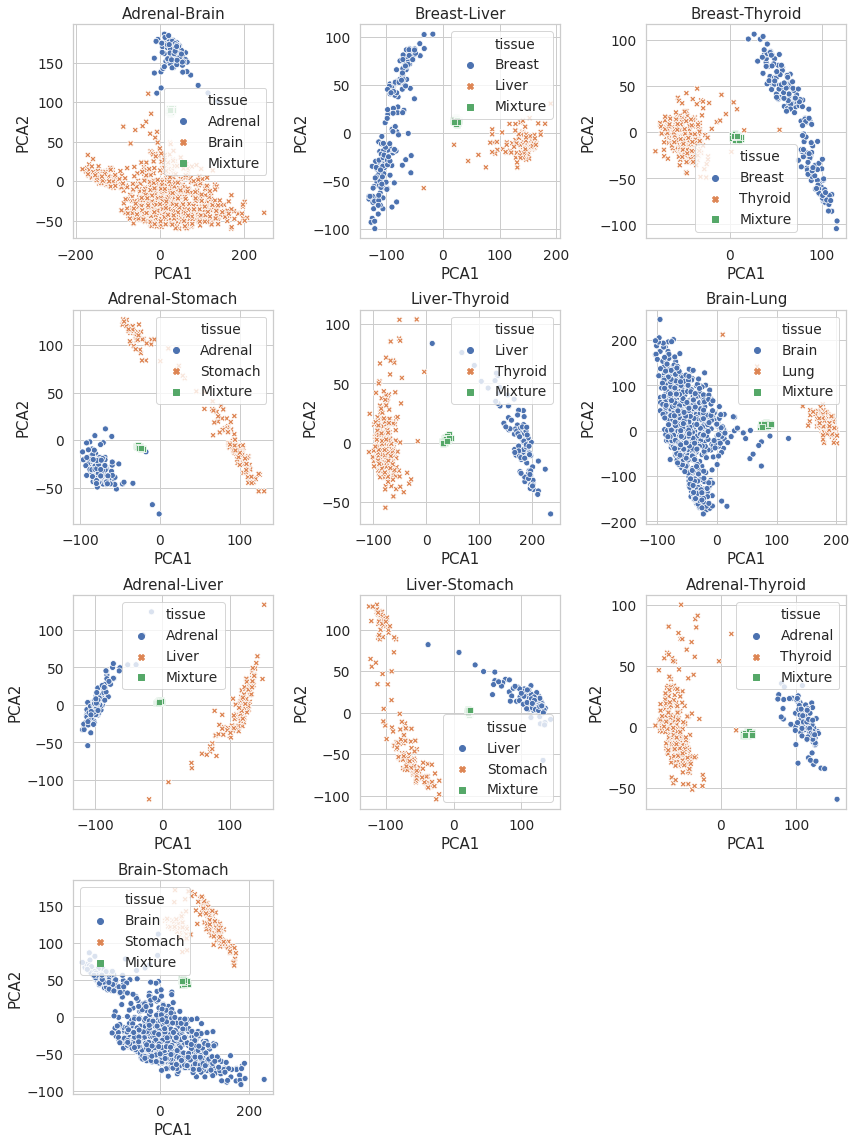

In [3]:
matrix_dir = '/mnt/normsd-outlier-runs/mixture-simulation/matrices'
m.plot_mixture_pca(matrix_dir);

## Generate Manifest for Run

Create a manifest for the Toil version of the workflow

In [6]:
out_dir = '/mnt/normsd-outlier-runs/mixture-simulation/'
m.manifest(tissues, matrix_dir, out_dir)

## Run Samples
Command used to run mixture samples
```
#!/usr/bin/env bash
source activate toil
python /mnt/gene-outlier-detection/toil/toil-outlier-detection.py \
    --sample /mnt/data/outlier/tumor.hd5 \
    --background /mnt/data/outlier/gtex.hd5 \
    --manifest /mnt/normsd-outlier-runs/mixture-simulation/manifest.tsv \
    --out-dir /mnt/normsd-outlier-runs/mixture-simulation/output \
    --gene-list /mnt/data/outlier/drug-genes.txt \
    --group tissue \
    --col-skip 5 \
    --num-backgrounds 4 \
    --max-genes 125 \
    --workDir /mnt/ \
    /mnt/jobStore
```

## Model Weights for Contributing Tissues

After running the mixture samples through the model, we can plot the weights assigned to the two tissues used to generate the mixture samples. Ideally, the model will assign split weight between each of the two contributing tissues.

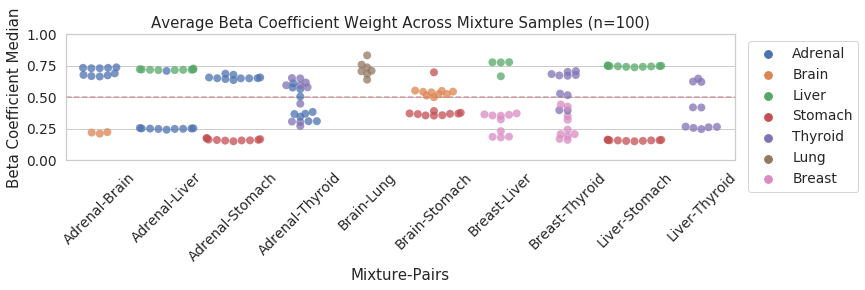

In [4]:
sample_dir = '/mnt/normsd-outlier-runs/mixture-simulation/output/'
wdf = m.weight_df(sample_dir)
m.plot_weight_swarm(wdf);
plt.tight_layout()
plt.savefig(
    '/mnt/figures/Mixture-Simulation/average-weight.png',
    dpi=300, 
    transparent=True
)

## Dimensionality Reductions of Mismatched Mixture Samples

Some of the mixture samples did not quite meet our expectation of being assigned a majority of the model weight. We can contextualize these results by plotting dimensionality reductions of those mixture samples alongside tissues that the model assigned weight to. 

In [5]:
sample_dir = '/mnt/normsd-outlier-runs/mixture-simulation/output/'
matrix_dir = '/mnt/normsd-outlier-runs/mixture-simulation/matrices'
wdf = Mixture.weight_df(sample_dir, only_contributing_tissues=False)

### Brain-Lung

Brain-Lung simulated mixture samples cluster more closely with prostate and breast tissue than brain or lung, which is reflected in the model's assignment of weight.

#### PCA

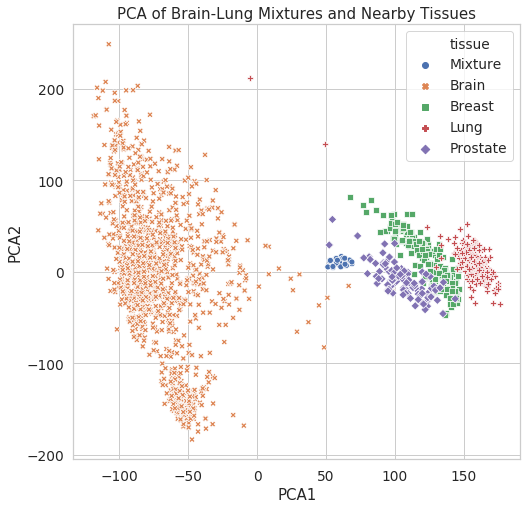

In [6]:
tissues = ['Brain', 'Lung', 'Breast', 'Prostate']
matrix_path = os.path.join(matrix_dir, 'Brain-Lung.hd5')
m.plot_pca_nearby_tissues(matrix_path, tissues);

#### Model Weight

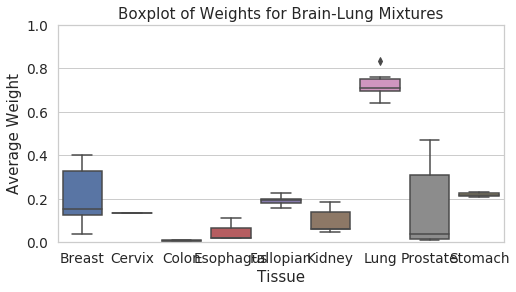

In [7]:
m.plot_weight_boxplot(wdf.sort_values('tissue'), label='Brain-Lung');

### Adrenal-Brain

Simulated Adrenal-Brain samples cluster near pituitary and kidney tissues. Adrenal tissue is also more homogenous than brain which might explain why the model prefers assign weight to adrenal samples over brain. 

#### PCA

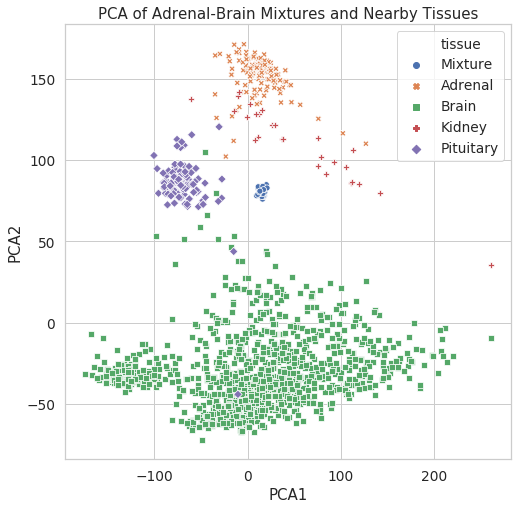

In [8]:
tissues = ['Adrenal', 'Brain', 'Kidney', 'Pituitary']
matrix_path = os.path.join(matrix_dir, 'Adrenal-Brain.hd5')
m.plot_pca_nearby_tissues(matrix_path, tissues);

#### Model Weight

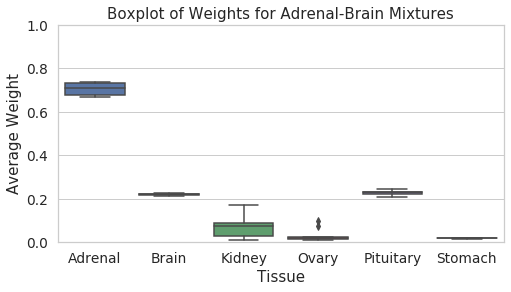

In [9]:
m.plot_weight_boxplot(wdf.sort_values('tissue'), label='Adrenal-Brain');

### Liver-Thyroid

Liver-Thyroid mixture samples don't get weight assigned to liver, but to thyroid, kidney, and minor salivary gland tissues. Although more proximal to liver than minor salivary gland across the first two principal components, minor samples are likely closer to the mixture samples along another component axis.

#### PCA

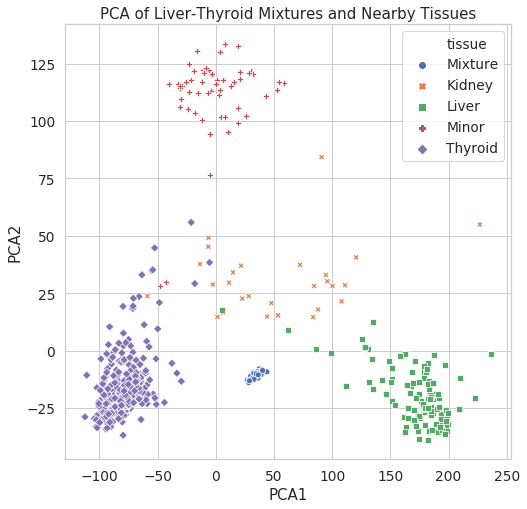

In [10]:
tissues = ['Thyroid', 'Liver', 'Kidney', 'Minor']
matrix_path = os.path.join(matrix_dir, 'Liver-Thyroid.hd5')
m.plot_pca_nearby_tissues(matrix_path, tissues);

#### Model Weight

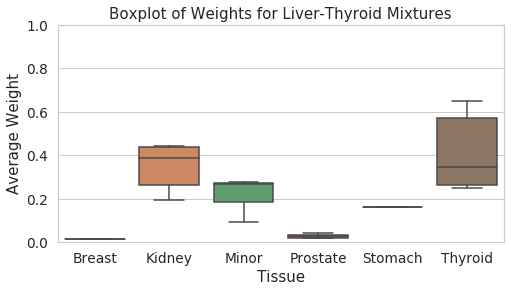

In [11]:
m.plot_weight_boxplot(wdf.sort_values('tissue'), label='Liver-Thyroid');